# Train AE model to have committor as encoder

In [6]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

Imports 

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from potentials.MullerBrown import MullerBrown
from simulations.UnbiasedMD import OverdampedLangevin

In [10]:
from committor.neural_net_models import CommittorOneDecoder
from committor.train_committor import TainCommittorOneDecoder

### Generate dataset with Boltzmann-Gibbs initial distribution of points. 

In [11]:
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
import random
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
seed = 345
set_all_seeds(seed)

Using device: cuda


In [12]:
pot = MullerBrown()
## Define the radius of the R and P sets
R_radius = 0.1
P_radius = 0.1
pot.set_R_radius(R_radius)
pot.set_P_radius(P_radius)
## Generate 100 penalization points on each boundary of R and P
theta = np.random.uniform(0,np.pi, size=[100])
pen_points = np.append(np.append(pot.minR + np.array([R_radius * np.cos(theta), R_radius * np.sin(theta)]).T, np.zeros([100, 1]), axis=1), np.append(pot.minP + np.array([P_radius * np.cos(theta), P_radius * np.sin(theta)]).T, np.ones([100, 1]), axis=1), axis=0)
## Re parameterise the MEP from the various steepest descent paths
MEP = [pot.minimum_energy_paths[0][0]]
i = 1
while i < len(pot.minimum_energy_paths[0]):
    if np.sqrt(np.sum((MEP[-1] - pot.minimum_energy_paths[0][i])**2)) > pot.dx:
        MEP.append(pot.minimum_energy_paths[0][i])
    i += 1
i = 1
while i < len(pot.minimum_energy_paths[1]):
    if np.sqrt(np.sum((MEP[-1] - pot.minimum_energy_paths[1][-i])**2)) > pot.dx:
        MEP.append(pot.minimum_energy_paths[1][-i])
    i += 1
MEP = np.array(MEP)

In [13]:
beta = 0.05
dt = 0.0001
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 2* 10**5

In [14]:
set_all_seeds(seed)
traj_dict = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=True)

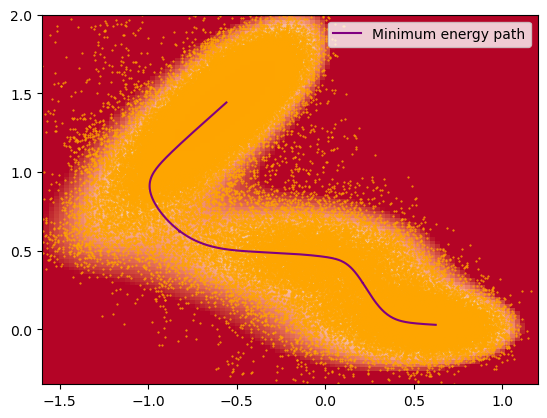

In [15]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax.scatter(traj_dict["x_traj"][:, 0], traj_dict["x_traj"][:, 1], marker=".", color="orange", s=1)
ax.legend()

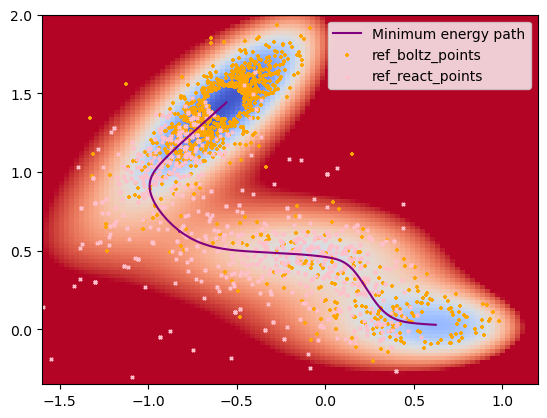

In [16]:
react_points = np.loadtxt('react_trajs_mullerbrown.txt')

ref_react_points = []
ref_boltz_points = [] 
for i in range(1000):
    index = np.random.choice(len(traj_dict["x_traj"]))
    while pot.in_P(traj_dict["x_traj"][index]) or pot.in_R(traj_dict["x_traj"][index]):
        index = np.random.choice(len(traj_dict["x_traj"]))
    ref_boltz_points.append(traj_dict["x_traj"][index])
    index = np.random.choice(len(react_points))
    while pot.in_P(react_points[index]) or pot.in_R(react_points[index]):
        index = np.random.choice(len(react_points))
    ref_react_points.append(react_points[index])
ref_react_points = np.array(ref_react_points)
ref_boltz_points = np.array(ref_boltz_points)

fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax.scatter(ref_boltz_points[:, 0], ref_boltz_points[:, 1], marker="+", color="orange", s=5, label="ref_boltz_points")
ax.scatter(ref_react_points[:, 0], ref_react_points[:, 1], marker="x", color="pink", s=5, label="ref_react_points")
ax.legend()

Gather the training dataset (stop the trajectories when R or P is reached (zeros gaussian and constant position to keep constant array shape))


In [17]:
set_all_seeds(0)

K = 8 * 10**2 # number of short trajectories 
N = 100 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], 
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           "multiple_trajs_pos": [], 
           "multiple_trajs_gauss": [], 
           "multiple_trajs_weights": [],
           'dt': dt, 'beta': beta}

for k in range(2 * K):
    x_traj = []
    gauss_traj = []
    second_trajs_pos = []
    second_trajs_gauss = []
    index = np.random.choice(n_steps - N)
    while pot.in_P(traj_dict["x_traj"][index]) or pot.in_R(traj_dict["x_traj"][index]):
        index = np.random.choice(n_steps - N)
    x_traj.append(traj_dict["x_traj"][index:index+1])
    second_trajs_pos.append(traj_dict["x_traj"][index:index+1])
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(x_traj[-1], 1, save_grad=False, save_gauss=True)
            x_traj.append(short_traj["x_traj"][0:1]) 
            gauss_traj.append(short_traj["gauss_traj"][0:1])
        else:
            x_traj.append(x_end)
            gauss_traj.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(second_trajs_pos[-1], 1, save_grad=False, save_gauss=True)
            second_trajs_pos.append(short_traj["x_traj"][0:1]) 
            second_trajs_gauss.append(short_traj["gauss_traj"][0:1])
        else:
            second_trajs_pos.append(x_end)
            second_trajs_gauss.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    dataset["multiple_trajs_pos"].append([x_traj, second_trajs_pos])
    dataset["multiple_trajs_gauss"].append([gauss_traj, second_trajs_gauss])
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
        dataset["multiple_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
        dataset["multiple_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["multiple_trajs_weights"] = np.array(dataset["multiple_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]
dataset["multiple_trajs_pos"] = np.array(dataset["multiple_trajs_pos"])[:, :, :, 0, :]
dataset["multiple_trajs_gauss"] = np.array(dataset["multiple_trajs_gauss"])[:, :, :, 0, :]
dataset["boltz_weights"] =  dataset["single_trajs_weights"] 
dataset["boltz_pos"] = dataset["single_trajs_pos"][:, 0, :]
dataset["boltz_pos_lagged"] = dataset["single_trajs_pos"][:, -1, :]

In [18]:
dataset["multiple_trajs_gauss"] = np.zeros_like(dataset["multiple_trajs_gauss"])

Import class for committor AE model and its training

Define the model 

In [ ]:
seeds = np.random.randint(10**6, size=10)
seeds 

In [19]:
del(committor)           # to restart from new model 
del(committor_training)

NameError: name 'committor' is not defined

In [25]:
seed = int(seeds[0])
set_all_seeds(seed)
committor = CommittorOneDecoder([2, 20, 20, 1], [1, 2], 0, pot, boundary_width=0.0001, handtanh=False)

In [28]:
# Set the loss function parameters 
loss_params = {}
dset = {}
dset["dt"] = dataset["dt"]
dset["beta"] = dataset["beta"]
loss_params["multiple_trajs_fixed_point_loss_weight_2"] = 1.0
dset["multiple_trajs_weights"] = dataset["multiple_trajs_weights"]
dset["multiple_trajs_pos"] = dataset["multiple_trajs_pos"]
dset["multiple_trajs_gauss"] = dataset["multiple_trajs_gauss"]
#dset["boltz_weights"][pot.in_R(dset["boltz_pos_lagged"]) * pot.in_R(dset["boltz_pos_lagged"])] = 2 * dset["boltz_weights"][pot.in_R(dset["boltz_pos_lagged"]) * pot.in_R(dset["boltz_pos_lagged"])]
#dset["boltz_weights"][pot.in_R(dset["boltz_pos"]) * pot.in_R(dset["boltz_pos"])] = 0 * dset["boltz_weights"][pot.in_R(dset["boltz_pos"]) * pot.in_R(dset["boltz_pos"])]

loss_params["n_wait"] = 50
# Create training object 
committor_training = TainCommittorOneDecoder(committor, pot, dset, penalization_points=pen_points, eps=1. * 10**(2))
# Do train test splitt of the dataset 
committor_training.train_test_split(train_size=K)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
# Set the optimizer 
committor_training.set_optimizer('Adam', 0.001)

committor_training.set_loss_weight(loss_params)
# Set the batch size and a max number of epochs 
batch_size = 10**3
max_epochs = 10000


ito_loss_weight value not provided, set to default value of:  0.0
log_ito_loss_weight value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
pen_points_weight value not provided, set to default value of:  0.0


In [29]:
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 3670 epochs.



Plot log of committor isolevels 

/tmp/ipykernel_16924/16972964.py:10: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_16924/16972964.py:20: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')


Text(0.5, 1.0, 'log(1 - committor) iso-levels')

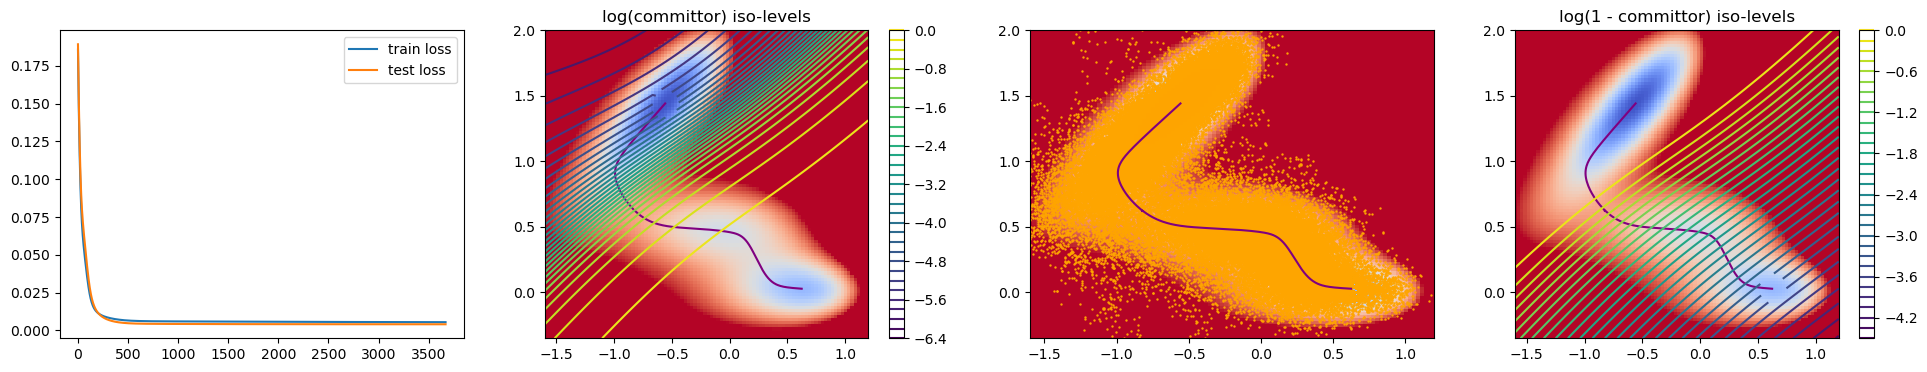

In [32]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax2.scatter(committor_training.dataset["multiple_trajs_pos"][:,:,:, 0], committor_training.dataset["multiple_trajs_pos"][:,:,:,1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

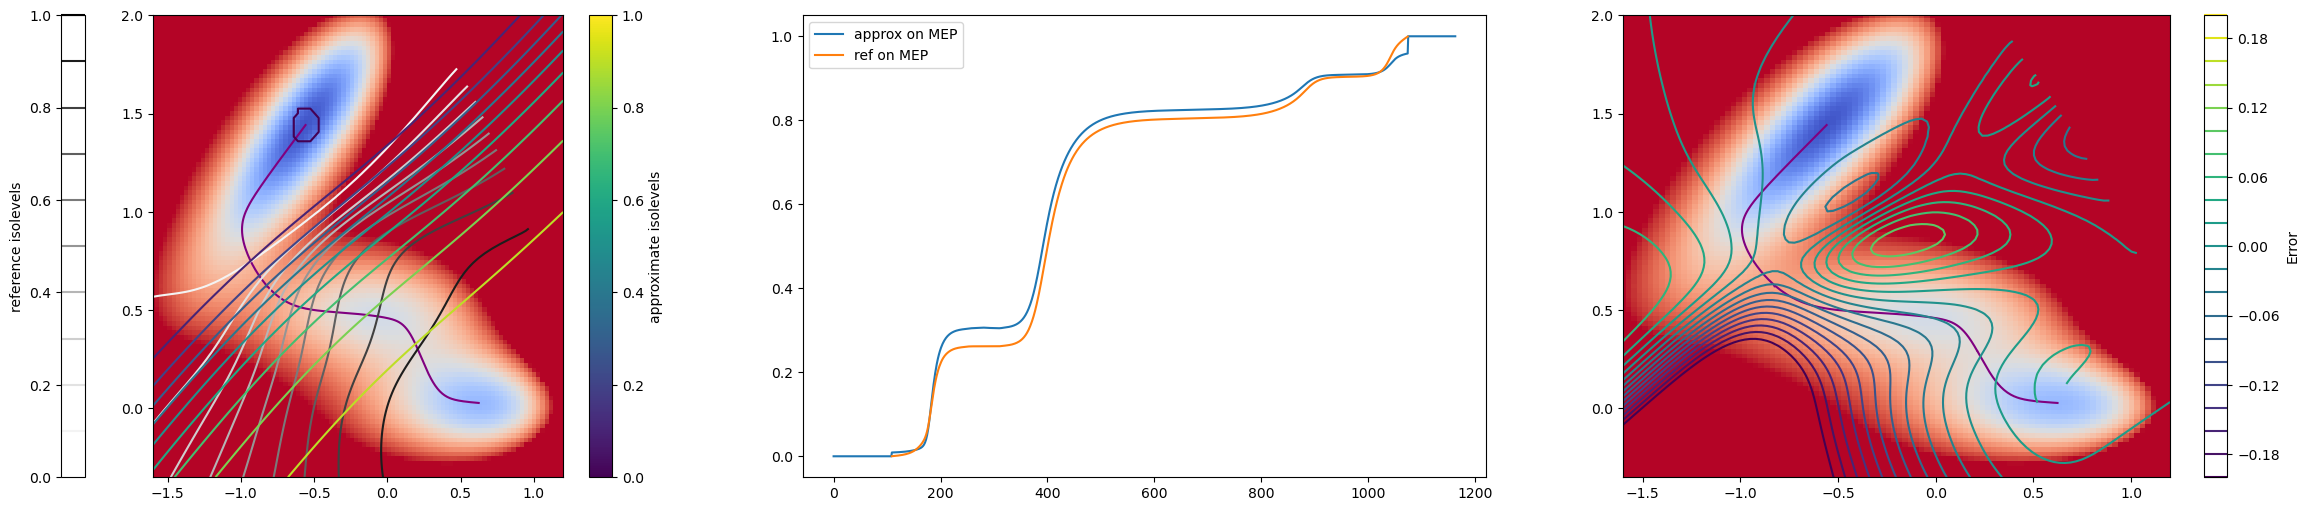

In [33]:
pts = np.loadtxt('mueller_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('mueller_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('Mueller_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

## Iso-levels of the approximate and reference committor function 
fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(30, 6)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
#contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.5, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location='left') 
#ax1.plot(pot.saddle_points[0][0,0], pot.saddle_points[0][0,1], marker="x", color="purple")
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location='right') 

## Plot the error Iso-levels 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, np.arange(-0.2, 0.22, 0.02), cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Error") 

# Plot the approximate and reference committor function along the minimum energy path
ref_committor_MEP = interp._interpolate_multikeys(x=MEP[:, 0], y=MEP[:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP = committor_training.committor_model.xi_forward(MEP)
err_MEP = committor_on_MEP - ref_committor_MEP
ax0.plot(committor_on_MEP, label="approx on MEP")
ax0.plot(ref_committor_MEP, label="ref on MEP")
#ax0.plot(err_MEP, label="error on MEP")
ax0.legend()

Plot committor iso-levels 

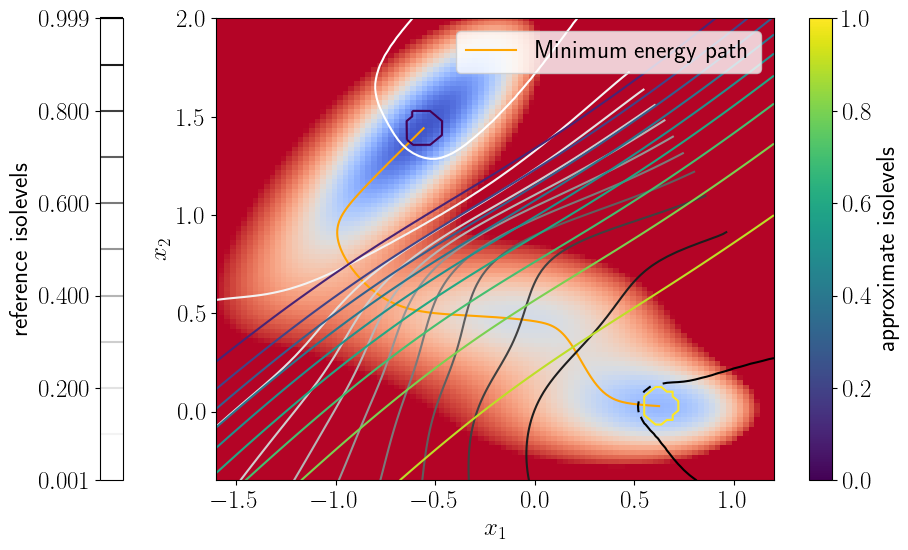

In [34]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

fig, (ax) = plt.subplots(1,1, figsize=(12, 6)) 
pot.set_2D_plot_grid_precision(100, 100)
pot.plot_potential_heat_map(ax)
ax.plot(MEP[:, 0], MEP[:, 1], color='orange', label='Minimum energy path')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
contour1 = ax.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax, np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]), set_lim=False)
fig.colorbar(contour1, ax=ax, label="reference isolevels", location='left') 
fig.colorbar(contour2, ax=ax, label="approximate isolevels", location='right') 
ax.legend()
#plt.savefig("isolevels_MB_committor_b.png", format='png', dpi=160)

Compute root mean squarred error of with respect to finite elements method solution on 1000 points sampled from the reactive trajectories density measure or boltzmann gibbs measure.  

In [35]:
ref_committor_react = interp._interpolate_multikeys(x=ref_react_points[:,0], y=ref_react_points[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(ref_react_points)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
log_RMSE_error = np.sqrt(np.mean((np.log(ref_committor_react) - np.log(app_committor_react))**2 + (np.log(1-ref_committor_react) - np.log(1-app_committor_react))**2))
print("RMSE react = ", RMSE)
print("log RMSE react = ", log_RMSE_error) 
ref_committor_boltz = interp._interpolate_multikeys(x=ref_boltz_points[:,0], y=ref_boltz_points[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_boltz = committor_training.committor_model.xi_forward(ref_boltz_points)[:, 0]
log_RMSE_error = np.sqrt(np.mean((np.log(ref_committor_boltz) - np.log(app_committor_boltz))**2 + (np.log(1-ref_committor_boltz) - np.log(1-app_committor_boltz))**2))
RMSE = np.sqrt(np.mean((ref_committor_boltz - app_committor_boltz)**2))
print("RMSE boltz = ", RMSE)
print("log RMSE boltz = ", log_RMSE_error) 

RMSE react =  0.05092263593061132
log RMSE react =  0.8004297654805818
RMSE boltz =  0.02058611369138003
log RMSE boltz =  3.162491772005974


fixed point ergo 2 
zero pen, boudary weight = 1 
RMSE react =  0.1802872149365765
log RMSE react =  1.1626687198230277
RMSE boltz =  0.08572584130304046
log RMSE boltz =  3.858772566988018

fixed point ergo 2 
10**2 pen, boudary weight = 1 
RMSE react =  0.09067782939046652
log RMSE react =  0.9967326041012757
RMSE boltz =  0.02937721320433889
log RMSE boltz =  1.9366304622078259

fixed point ergo 1 
zero pen, boudary weight = 2 
RMSE react =  0.1598562179796417
log RMSE react =  1.1622618266255713
RMSE boltz =  0.08276819984325688
log RMSE boltz =  4.070554370868335

fixed point ergo 1 
10**2 pen, boudary weight = 2 
RMSE react =  0.12811576799987148
log RMSE react =  1.8005426182347481
RMSE boltz =  0.040397938908741035
log RMSE boltz =  2.2517493987838835

In [46]:
set_all_seeds(0)

K = 4 * 10**4 # number of short trajectories 
N = 100 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], 
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           "multiple_trajs_pos": [], 
           "multiple_trajs_gauss": [], 
           "multiple_trajs_weights": [],
           'dt': dt, 'beta': beta}

for k in range(2 * K):
    x_traj = []
    gauss_traj = []
    second_trajs_pos = []
    second_trajs_gauss = []
    index = np.random.choice(n_steps - N)
    while pot.in_P(traj_dict["x_traj"][index]) or pot.in_R(traj_dict["x_traj"][index]):
        index = np.random.choice(n_steps - N)
    x_traj.append(traj_dict["x_traj"][index:index+1])
    second_trajs_pos.append(traj_dict["x_traj"][index:index+1])
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(x_traj[-1], 1, save_grad=False, save_gauss=True)
            x_traj.append(short_traj["x_traj"][0:1]) 
            gauss_traj.append(short_traj["gauss_traj"][0:1])
        else:
            x_traj.append(x_end)
            gauss_traj.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(second_trajs_pos[-1], 1, save_grad=False, save_gauss=True)
            second_trajs_pos.append(short_traj["x_traj"][0:1]) 
            second_trajs_gauss.append(short_traj["gauss_traj"][0:1])
        else:
            second_trajs_pos.append(x_end)
            second_trajs_gauss.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    dataset["multiple_trajs_pos"].append([x_traj, second_trajs_pos])
    dataset["multiple_trajs_gauss"].append([gauss_traj, second_trajs_gauss])
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
        dataset["multiple_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
        dataset["multiple_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["multiple_trajs_weights"] = np.array(dataset["multiple_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]
dataset["multiple_trajs_pos"] = np.array(dataset["multiple_trajs_pos"])[:, :, :, 0, :]
dataset["multiple_trajs_gauss"] = np.array(dataset["multiple_trajs_gauss"])[:, :, :, 0, :]
dataset["boltz_weights"] =  dataset["single_trajs_weights"] 
dataset["boltz_pos"] = dataset["single_trajs_pos"][:, 0, :]
dataset["boltz_pos_lagged"] = dataset["single_trajs_pos"][:, -1, :]

In [47]:
dataset["multiple_trajs_gauss"] = np.zeros_like(dataset["multiple_trajs_gauss"])

In [24]:
seeds = np.array([33246, 125944, 139947, 640561, 134189, 551652, 486310,   1926, 898666, 405339, 
                  33246, 125944, 139947, 640561, 134189, 551652, 486310,   1926, 898666, 405339,
                  33246, 125944, 139947, 640561, 134189, 551652, 486310,   1926, 898666, 405339,
                  33246, 125944, 139947, 640561, 134189, 551652, 486310,   1926, 898666, 405339
                ])
seeds 

array([ 33246, 125944, 139947, 640561, 134189, 551652, 486310,   1926,
       898666, 405339,  33246, 125944, 139947, 640561, 134189, 551652,
       486310,   1926, 898666, 405339,  33246, 125944, 139947, 640561,
       134189, 551652, 486310,   1926, 898666, 405339,  33246, 125944,
       139947, 640561, 134189, 551652, 486310,   1926, 898666, 405339])

In [38]:
results_dict = {"seeds": seeds.tolist(), "RMSE react": [], "RMSE boltz": [], "log RMSE react": [],"log RMSE boltz": []}

In [40]:
for i in range(10):
    set_all_seeds(int(seeds[i]))
    committor = CommittorOneDecoder([2, 20, 20, 1], [1, 2], 0, pot, boundary_width=0.0001, handtanh=False)
    # Create training object 
    loss_params = {}
    dset = {}
    dset["dt"] = dataset["dt"]
    dset["beta"] = dataset["beta"]
    if i < 10:
        loss_params["squared_grad_boltz_weight"] = 1. * 10**(0)
        loss_params["pen_points_weight"] = 1. * 10**(2)
        dset["boltz_pos"] = traj_dict["x_traj"][:-N]
        dset["boltz_weights"] = np.ones([dset["boltz_pos"].shape[0],1])
    """
    if i < 10:
        N = 50
        loss_params["boltz_traj_fixed_point_loss_weight_2"] = 1. * 10**(0)
        loss_params["pen_points_weight"] = 1. * 10**(2)
        dset["boltz_pos_lagged"] = traj_dict["x_traj"][N:]
        dset["boltz_pos"] = traj_dict["x_traj"][:-N]
        dset["boltz_weights"] = np.ones([dset["boltz_pos"].shape[0],1])
    if 10 <= i < 20:
        N=100
        loss_params["boltz_traj_fixed_point_loss_weight_2"] = 1. * 10**(0)
        loss_params["pen_points_weight"] = 1. * 10**(2)
        dset["boltz_pos_lagged"] = traj_dict["x_traj"][N:]
        dset["boltz_pos"] = traj_dict["x_traj"][:-N]
        dset["boltz_weights"] = np.ones([dset["boltz_pos"].shape[0],1])
    if 20 <= i < 30:
        N=150
        loss_params["boltz_traj_fixed_point_loss_weight_2"] = 1. * 10**(0)
        loss_params["pen_points_weight"] = 1. * 10**(2)
        dset["boltz_pos_lagged"] = traj_dict["x_traj"][N:]
        dset["boltz_pos"] = traj_dict["x_traj"][:-N]
        dset["boltz_weights"] = np.ones([dset["boltz_pos"].shape[0],1])
    
    if i < 10:
        loss_params["ito_loss_weight"] = 1.0
        dset["single_trajs_weights"] = dataset["single_trajs_weights"]
        dset["single_trajs_gauss"] = dataset["single_trajs_gauss"]
        dset["single_trajs_pos"] = dataset["single_trajs_pos"]
    if 10 <= i < 20:
        loss_params["squared_grad_boltz_weight"] = 1. * 10**(0)
        loss_params["pen_points_weight"] = 1. * 10**(2)
        dset["boltz_pos"] = dataset["boltz_pos"]
        dset["boltz_weights"] = dataset["boltz_weights"]
    if 20 <= i < 30:
        loss_params["multiple_trajs_fixed_point_loss_weight_2"] = 1.0
        dset["multiple_trajs_weights"] = dataset["multiple_trajs_weights"]
        dset["multiple_trajs_pos"] = dataset["multiple_trajs_pos"]
        dset["multiple_trajs_gauss"] = dataset["multiple_trajs_gauss"]
    """        
    loss_params["n_wait"] = 50
    committor_training = TainCommittorOneDecoder(committor, pot, dset, penalization_points=pen_points, eps=1. * 10**(0))
    # Do train test splitt of the dataset 
    committor_training.train_test_split(train_size=8 * 10**4)
    committor_training.split_training_dataset_K_folds(2)
    committor_training.set_train_val_data(0)
    # Set the optimizer 
    committor_training.set_optimizer('Adam', 0.001)
    # Set the loss function parameters 
    
    committor_training.set_loss_weight(loss_params)
    # Set the batch size and a max number of epochs 
    batch_size = 10**3
    max_epochs = 10000
    loss_dict = committor_training.train(batch_size, max_epochs)

    ref_committor_react = interp._interpolate_multikeys(x=ref_react_points[:,0], y=ref_react_points[:,1], tri_index=None, return_keys=('z',))[0]
    app_committor_react = committor_training.committor_model.xi_forward(ref_react_points)[:, 0]
    RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
    log_RMSE_error = np.sqrt(np.mean((np.log(ref_committor_react) - np.log(app_committor_react))**2 + (np.log(1-ref_committor_react) - np.log(1-app_committor_react))**2))
    results_dict["RMSE react"].append(RMSE)
    results_dict["log RMSE react"].append(log_RMSE_error)
    ref_committor_boltz = interp._interpolate_multikeys(x=ref_boltz_points[:,0], y=ref_boltz_points[:,1], tri_index=None, return_keys=('z',))[0]
    app_committor_boltz = committor_training.committor_model.xi_forward(ref_boltz_points)[:, 0]
    log_RMSE_error = np.sqrt(np.mean((np.log(ref_committor_boltz) - np.log(app_committor_boltz))**2 + (np.log(1-ref_committor_boltz) - np.log(1-app_committor_boltz))**2))
    RMSE = np.sqrt(np.mean((ref_committor_boltz - app_committor_boltz)**2))
    results_dict["RMSE boltz"].append(RMSE)
    results_dict["log RMSE boltz"].append(log_RMSE_error)

ito_loss_weight value not provided, set to default value of:  0.0
log_ito_loss_weight value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
training ends after 417 epochs.

ito_loss_weight value not provided, set to default value of:  0.0
log_ito_loss_weight value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_1 value not provided, set to default value of:

In [44]:
results_dict["RMSE boltz"][:10]


[0.10891708884132982,
 0.33267064056939916,
 0.011890991601910183,
 0.30823527958131297,
 0.16373595856627557,
 0.008779457821050876,
 0.005299209269119653,
 0.006364460801093669,
 0.006702190256369108,
 0.06626689936583721]

In [ ]:
import json 
with open("3 fxpt_10_seeds_boltz_50_100_150.txt", "w") as fp:
    json.dump(results_dict, fp)  # encode dict into JSON


In [ ]:
set_all_seeds(0)

K = 8 * 10**3 # number of short trajectories 
N = 100 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], 
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           "multiple_trajs_pos": [], 
           "multiple_trajs_gauss": [], 
           "multiple_trajs_weights": [],
           'dt': dt, 'beta': beta}

for k in range(2 * K):
    x_traj = []
    gauss_traj = []
    second_trajs_pos = []
    second_trajs_gauss = []
    index = np.random.choice(n_steps - N)
    while pot.in_P(traj_dict["x_traj"][index]) or pot.in_R(traj_dict["x_traj"][index]):
        index = np.random.choice(n_steps - N)
    x_traj.append(traj_dict["x_traj"][index:index+1])
    second_trajs_pos.append(traj_dict["x_traj"][index:index+1])
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(x_traj[-1], 1, save_grad=False, save_gauss=True)
            x_traj.append(short_traj["x_traj"][0:1]) 
            gauss_traj.append(short_traj["gauss_traj"][0:1])
        else:
            x_traj.append(x_end)
            gauss_traj.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(second_trajs_pos[-1], 1, save_grad=False, save_gauss=True)
            second_trajs_pos.append(short_traj["x_traj"][0:1]) 
            second_trajs_gauss.append(short_traj["gauss_traj"][0:1])
        else:
            second_trajs_pos.append(x_end)
            second_trajs_gauss.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    dataset["multiple_trajs_pos"].append([x_traj, second_trajs_pos])
    dataset["multiple_trajs_gauss"].append([gauss_traj, second_trajs_gauss])
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
        dataset["multiple_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
        dataset["multiple_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["multiple_trajs_weights"] = np.array(dataset["multiple_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]
dataset["multiple_trajs_pos"] = np.array(dataset["multiple_trajs_pos"])[:, :, :, 0, :]
dataset["multiple_trajs_gauss"] = np.array(dataset["multiple_trajs_gauss"])[:, :, :, 0, :]
dataset["boltz_weights"] =  dataset["single_trajs_weights"] 
dataset["boltz_pos"] = dataset["single_trajs_pos"][:, 0, :]
dataset["boltz_pos_lagged"] = dataset["single_trajs_pos"][:, -1, :]

In [ ]:
dataset["multiple_trajs_gauss"] = np.zeros_like(dataset["multiple_trajs_gauss"])

In [ ]:
dataset.keys()

In [ ]:
results_dict = {"seeds": seeds.tolist(), "RMSE react": [], "RMSE boltz": [], "log RMSE react": [],"log RMSE boltz": []}

In [ ]:
for i in range(20):
    set_all_seeds(int(seeds[i]))
    committor = CommittorOneDecoder([2, 20, 20, 1], [1, 2], 0, pot, boundary_width=0.0001, handtanh=False)
    # Create training object 
    loss_params = {}
    dset = {}
    dset["dt"] = dataset["dt"]
    dset["beta"] = dataset["beta"]
    if i < 10:
        loss_params["pen_points_weight"] = 0. * 10**(2)
        loss_params["boltz_traj_fixed_point_loss_weight"] = 1. * 10**(0)
        dset["boltz_pos_lagged"] = dataset["boltz_pos_lagged"]
        dset["boltz_pos"] = dataset["boltz_pos"]
        dset["boltz_weights"] = dataset["boltz_weights"]
        dset["boltz_weights"][pot.in_R(dset["boltz_pos_lagged"]) * pot.in_R(dset["boltz_pos_lagged"])] = 2 * dset["boltz_weights"][pot.in_R(dset["boltz_pos_lagged"]) * pot.in_R(dset["boltz_pos_lagged"])]
    if 10 <= i < 20:
        loss_params["pen_points_weight"] = 0. * 10**(2)
        loss_params["boltz_traj_fixed_point_loss_weight"] = 1. * 10**(0)
        dset["boltz_pos_lagged"] = dataset["boltz_pos_lagged"]
        dset["boltz_pos"] = dataset["boltz_pos"]
        dset["boltz_weights"] = dataset["boltz_weights"]
        dset["boltz_weights"][pot.in_R(dset["boltz_pos_lagged"]) * pot.in_R(dset["boltz_pos_lagged"])] = 2 * dset["boltz_weights"][pot.in_R(dset["boltz_pos_lagged"]) * pot.in_R(dset["boltz_pos_lagged"])]
"""
    if 20 <= i < 30:
        loss_params["boltz_traj_fixed_point_loss_weight"] = 1. * 10**(0)
        dset["boltz_pos_lagged"] = dataset["boltz_pos_lagged"]
        dset["boltz_pos"] = dataset["boltz_pos"]
        dset["boltz_weights"] = dataset["boltz_weights"]
    if 30 <= i < 40:
        loss_params["ito_loss_weight"] = 1.0
        dset["single_trajs_weights"] = dataset["single_trajs_weights"]
        dset["single_trajs_gauss"] = dataset["single_trajs_gauss"]
        dset["single_trajs_pos"] = dataset["single_trajs_pos"]
"""
    loss_params["n_wait"] = 50
    committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dset, penalization_points=pen_points, eps=1. * 10**(0))
    # Do train test splitt of the dataset 
    committor_training.train_test_split(train_size=K)
    committor_training.split_training_dataset_K_folds(2)
    committor_training.set_train_val_data(0)
    # Set the optimizer 
    committor_training.set_optimizer('Adam', 0.001)
    # Set the loss function parameters 
    
    committor_training.set_loss_weight(loss_params)
    # Set the batch size and a max number of epochs 
    batch_size = 10**2
    max_epochs = 10000
    loss_dict = committor_training.train(batch_size, max_epochs)

    ref_committor_react = interp._interpolate_multikeys(x=ref_react_points[:,0], y=ref_react_points[:,1], tri_index=None, return_keys=('z',))[0]
    app_committor_react = committor_training.committor_model.xi_forward(ref_react_points)[:, 0]
    RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
    log_RMSE_error = np.sqrt(np.mean((np.log(ref_committor_react) - np.log(app_committor_react))**2 + (np.log(1-ref_committor_react) - np.log(1-app_committor_react))**2))
    results_dict["RMSE react"].append(RMSE)
    results_dict["log RMSE react"].append(log_RMSE_error)
    ref_committor_boltz = interp._interpolate_multikeys(x=ref_boltz_points[:,0], y=ref_boltz_points[:,1], tri_index=None, return_keys=('z',))[0]
    app_committor_boltz = committor_training.committor_model.xi_forward(ref_boltz_points)[:, 0]
    log_RMSE_error = np.sqrt(np.mean((np.log(ref_committor_boltz) - np.log(app_committor_boltz))**2 + (np.log(1-ref_committor_boltz) - np.log(1-app_committor_boltz))**2))
    RMSE = np.sqrt(np.mean((ref_committor_boltz - app_committor_boltz)**2))
    results_dict["RMSE boltz"].append(RMSE)
    results_dict["log RMSE boltz"].append(log_RMSE_error)

In [ ]:
results_dict["RMSE react"]

In [ ]:
import json 
with open("3_losses_10_seeds_boltz_8000_100_Tanh.txt", "w") as fp:
    json.dump(results_dict, fp)  # encode dict into JSON


### Generate dataset with Uniform distribution of configurations. 

In [ ]:
set_all_seeds(0)

K = 8 * 10**2 # number of short trajectories 
N = 100 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], 
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           "multiple_trajs_pos": [], 
           "multiple_trajs_gauss": [], 
           "multiple_trajs_weights": [],
           'dt': dt, 'beta': beta}

for k in range(2 * K):
    x_traj = []
    gauss_traj = []
    second_trajs_pos = []
    second_trajs_gauss = []
    x_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 0]) - np.min(pot.x2d[:, 0])) + np.min(pot.x2d[:, 0])
    y_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 1]) - np.min(pot.x2d[:, 1])) + np.min(pot.x2d[:, 1])
    x_0 = np.array([x_ini,y_ini]).T
    while pot.in_P(traj_dict["x_traj"][index]) or pot.in_R(traj_dict["x_traj"][index]):
        x_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 0]) - np.min(pot.x2d[:, 0])) + np.min(pot.x2d[:, 0])
        y_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 1]) - np.min(pot.x2d[:, 1])) + np.min(pot.x2d[:, 1])
        x_0 = np.array([x_ini,y_ini]).T
    x_traj.append(x_0)
    second_trajs_pos.append(x_O)
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(x_traj[-1], 1, save_grad=False, save_gauss=True)
            x_traj.append(short_traj["x_traj"][0:1]) 
            gauss_traj.append(short_traj["gauss_traj"][0:1])
        else:
            x_traj.append(x_end)
            gauss_traj.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(second_trajs_pos[-1], 1, save_grad=False, save_gauss=True)
            second_trajs_pos.append(short_traj["x_traj"][0:1]) 
            second_trajs_gauss.append(short_traj["gauss_traj"][0:1])
        else:
            second_trajs_pos.append(x_end)
            second_trajs_gauss.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    dataset["multiple_trajs_pos"].append([x_traj, second_trajs_pos])
    dataset["multiple_trajs_gauss"].append([gauss_traj, second_trajs_gauss])
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
        dataset["multiple_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
        dataset["multiple_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["multiple_trajs_weights"] = np.array(dataset["multiple_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]
dataset["multiple_trajs_pos"] = np.array(dataset["multiple_trajs_pos"])[:, :, :, 0, :]
dataset["multiple_trajs_gauss"] = np.array(dataset["multiple_trajs_gauss"])[:, :, :, 0, :]
dataset["boltz_weights"] =  dataset["single_trajs_weights"] 
dataset["boltz_pos"] = dataset["single_trajs_pos"][:, 0, :]
dataset["boltz_pos_lagged"] = dataset["single_trajs_pos"][:, -1, :]

In [ ]:
dataset["multiple_trajs_gauss"] = np.zeros_like(dataset["multiple_trajs_gauss"])

In [ ]:
results_dict = {"seeds": seeds.tolist(), "RMSE react": [], "RMSE boltz": [], "log RMSE react": [],"log RMSE boltz": []}

In [ ]:
for i, seed in enumerate(results_dict["seeds"]):
    set_all_seeds(seed)
    committor = CommittorOneDecoder([2, 20, 20, 1], [1, 2], 0, pot, boundary_width=0.0001, handtanh=False)
    # Create training object 
    loss_params = {}
    dset = {}
    dset["dt"] = dataset["dt"]
    dset["beta"] = dataset["beta"]
    if i < 10:
        loss_params["ito_loss_weight"] = 1.0
        dset["single_trajs_weights"] = dataset["single_trajs_weights"]
        dset["single_trajs_gauss"] = dataset["single_trajs_gauss"]
        dset["single_trajs_pos"] = dataset["single_trajs_pos"]
    if 10 <= i < 20:
        loss_params["multiple_trajs_fixed_point_loss_weight_2"] = 1.0
        dset["multiple_trajs_weights"] = dataset["multiple_trajs_weights"]
        dset["multiple_trajs_pos"] = dataset["multiple_trajs_pos"]
        dset["multiple_trajs_gauss"] = dataset["multiple_trajs_gauss"]
    if 20 <= i < 30:
        loss_params["boltz_traj_fixed_point_loss_weight"] = 1. * 10**(0)
        dset["boltz_pos_lagged"] = dataset["boltz_pos_lagged"]
        dset["boltz_pos"] = dataset["boltz_pos"]
        dset["boltz_weights"] = dataset["boltz_weights"]
    if 30 <= i < 40:
        loss_params["squared_grad_boltz_weight"] = 1. * 10**(0)
        loss_params["pen_points_weight"] = 1. * 10**(2)
        dset["boltz_pos"] = dataset["boltz_pos"]
        dset["boltz_weights"] = dataset["boltz_weights"]
    loss_params["n_wait"] = 50
    committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dset, penalization_points=pen_points, eps=1. * 10**(0))
    # Do train test splitt of the dataset 
    committor_training.train_test_split(train_size=K)
    committor_training.split_training_dataset_K_folds(2)
    committor_training.set_train_val_data(0)
    # Set the optimizer 
    committor_training.set_optimizer('Adam', 0.001)
    # Set the loss function parameters 
    
    committor_training.set_loss_weight(loss_params)
    # Set the batch size and a max number of epochs 
    batch_size = 10**2
    max_epochs = 10000
    loss_dict = committor_training.train(batch_size, max_epochs)

    ref_committor_react = interp._interpolate_multikeys(x=ref_react_points[:,0], y=ref_react_points[:,1], tri_index=None, return_keys=('z',))[0]
    app_committor_react = committor_training.committor_model.xi_forward(ref_react_points)[:, 0]
    RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
    log_RMSE_error = np.sqrt(np.mean((np.log(ref_committor_react) - np.log(app_committor_react))**2 + (np.log(1-ref_committor_react) - np.log(1-app_committor_react))**2))
    results_dict["RMSE react"].append(RMSE)
    results_dict["log RMSE react"].append(log_RMSE_error)
    ref_committor_boltz = interp._interpolate_multikeys(x=ref_boltz_points[:,0], y=ref_boltz_points[:,1], tri_index=None, return_keys=('z',))[0]
    app_committor_boltz = committor_training.committor_model.xi_forward(ref_boltz_points)[:, 0]
    log_RMSE_error = np.sqrt(np.mean((np.log(ref_committor_boltz) - np.log(app_committor_boltz))**2 + (np.log(1-ref_committor_boltz) - np.log(1-app_committor_boltz))**2))
    RMSE = np.sqrt(np.mean((ref_committor_boltz - app_committor_boltz)**2))
    results_dict["RMSE boltz"].append(RMSE)
    results_dict["log RMSE boltz"].append(log_RMSE_error)

In [ ]:
import json 
with open("4_losses_10_seeds_unif_800_100_Tanh.txt", "w") as fp:
    json.dump(results_dict, fp)  # encode dict into JSON

In [ ]:
set_all_seeds(0)

K = 8 * 10**3 # number of short trajectories 
N = 100 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], 
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           "multiple_trajs_pos": [], 
           "multiple_trajs_gauss": [], 
           "multiple_trajs_weights": [],
           'dt': dt, 'beta': beta}

for k in range(2 * K):
    x_traj = []
    gauss_traj = []
    second_trajs_pos = []
    second_trajs_gauss = []
    x_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 0]) - np.min(pot.x2d[:, 0])) + np.min(pot.x2d[:, 0])
    y_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 1]) - np.min(pot.x2d[:, 1])) + np.min(pot.x2d[:, 1])
    x_0 = np.array([x_ini,y_ini]).T
    while pot.in_P(traj_dict["x_traj"][index]) or pot.in_R(traj_dict["x_traj"][index]):
        x_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 0]) - np.min(pot.x2d[:, 0])) + np.min(pot.x2d[:, 0])
        y_ini = np.random.ranf(1) * (np.max(pot.x2d[:, 1]) - np.min(pot.x2d[:, 1])) + np.min(pot.x2d[:, 1])
        x_0 = np.array([x_ini,y_ini]).T
    x_traj.append(x_0)
    second_trajs_pos.append(x_O)
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(x_traj[-1], 1, save_grad=False, save_gauss=True)
            x_traj.append(short_traj["x_traj"][0:1]) 
            gauss_traj.append(short_traj["gauss_traj"][0:1])
        else:
            x_traj.append(x_end)
            gauss_traj.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(second_trajs_pos[-1], 1, save_grad=False, save_gauss=True)
            second_trajs_pos.append(short_traj["x_traj"][0:1]) 
            second_trajs_gauss.append(short_traj["gauss_traj"][0:1])
        else:
            second_trajs_pos.append(x_end)
            second_trajs_gauss.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    dataset["multiple_trajs_pos"].append([x_traj, second_trajs_pos])
    dataset["multiple_trajs_gauss"].append([gauss_traj, second_trajs_gauss])
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
        dataset["multiple_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
        dataset["multiple_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["multiple_trajs_weights"] = np.array(dataset["multiple_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]
dataset["multiple_trajs_pos"] = np.array(dataset["multiple_trajs_pos"])[:, :, :, 0, :]
dataset["multiple_trajs_gauss"] = np.array(dataset["multiple_trajs_gauss"])[:, :, :, 0, :]
dataset["boltz_weights"] =  dataset["single_trajs_weights"] 
dataset["boltz_pos"] = dataset["single_trajs_pos"][:, 0, :]
dataset["boltz_pos_lagged"] = dataset["single_trajs_pos"][:, -1, :]

In [ ]:
dataset["multiple_trajs_gauss"] = np.zeros_like(dataset["multiple_trajs_gauss"])

In [ ]:
results_dict = {"seeds": seeds.tolist(), "RMSE react": [], "RMSE boltz": [], "log RMSE react": [],"log RMSE boltz": []}

In [ ]:
for i, seed in enumerate(results_dict["seeds"]):
    set_all_seeds(seed)
    committor = CommittorOneDecoder([2, 20, 20, 1], [1, 2], 0, pot, boundary_width=0.0001, handtanh=False)
    # Create training object 
    committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset, penalization_points=pen_points, eps=1. * 10**(0))
    # Do train test splitt of the dataset 
    committor_training.train_test_split(train_size=K)
    committor_training.split_training_dataset_K_folds(2)
    committor_training.set_train_val_data(0)
    # Set the optimizer 
    committor_training.set_optimizer('Adam', 0.001)
    # Set the loss function parameters 
    loss_params = {}
    if i < 10:
        loss_params["ito_loss_weight"] = 1.0
    if 10 <= i < 20:
        loss_params["multiple_trajs_fixed_point_loss_weight_2"] = 1.0
    if 20 <= i < 30:
        loss_params["boltz_traj_fixed_point_loss_weight"] = 1. * 10**(0)
    if 30 <= i < 40:
        loss_params["squared_grad_boltz_weight"] = 1. * 10**(0)
        loss_params["pen_points_weight"] = 1. * 10**(2)
    loss_params["n_wait"] = 50
    committor_training.set_loss_weight(loss_params)
    # Set the batch size and a max number of epochs 
    batch_size = 10**2
    max_epochs = 10000
    loss_dict = committor_training.train(batch_size, max_epochs)

    ref_committor_react = interp._interpolate_multikeys(x=ref_react_points[:,0], y=ref_react_points[:,1], tri_index=None, return_keys=('z',))[0]
    app_committor_react = committor_training.committor_model.xi_forward(ref_react_points)[:, 0]
    RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
    log_RMSE_error = np.sqrt(np.mean((np.log(ref_committor_react) - np.log(app_committor_react))**2 + (np.log(1-ref_committor_react) - np.log(1-app_committor_react))**2))
    results_dict["RMSE react"].append(RMSE)
    results_dict["log RMSE react"].append(log_RMSE_error)
    ref_committor_boltz = interp._interpolate_multikeys(x=ref_boltz_points[:,0], y=ref_boltz_points[:,1], tri_index=None, return_keys=('z',))[0]
    app_committor_boltz = committor_training.committor_model.xi_forward(ref_boltz_points)[:, 0]
    log_RMSE_error = np.sqrt(np.mean((np.log(ref_committor_boltz) - np.log(app_committor_boltz))**2 + (np.log(1-ref_committor_boltz) - np.log(1-app_committor_boltz))**2))
    RMSE = np.sqrt(np.mean((ref_committor_boltz - app_committor_boltz)**2))
    results_dict["RMSE boltz"].append(RMSE)
    results_dict["log RMSE boltz"].append(log_RMSE_error)

In [ ]:
import json 
with open("4_losses_10_seeds_unif_8000_100_Tanh.txt", "w") as fp:
    json.dump(results_dict, fp)  # encode dict into JSON

Generate dataset in which the trajectory is stopped once R or P is reached

In [ ]:
x_0 = dataset["single_trajs_pos"][0][1:2]
x_p = dataset["single_trajs_pos"][0][2:3]
G = dataset["single_trajs_gauss"][0][1:2]
print(x_0 - pot.nabla_V(x_0) * dt + np.sqrt(2 * dt / beta)  * G)
print(x_p)

In [ ]:
dataset["single_trajs_weights"] = np.ones_like(dataset["single_trajs_weights"])

In [ ]:
np.random.randint(10**6, size=10)

In [ ]:
del(committor)           # to restart from new model 
del(committor_training)
seed = 328801
set_all_seeds(seed)
committor = CommittorOneDecoder([2, 20, 20, 1], [1, 2], 0, pot, boundary_width=0.0001)
committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset, penalization_points=pen_points)

committor_training.train_test_split(train_size=K)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)

committor_training.set_optimizer('Adam', 0.001)

loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 1.0 * 10**2
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

batch_size = 10**3
max_epochs = 10000

loss_dict = committor_training.train(batch_size, max_epochs)

Plot approximate committor iso-levels

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

fig, (ax) = plt.subplots(1,1, figsize=(12, 6)) 
pot.set_2D_plot_grid_precision(100, 100)
pot.plot_potential_heat_map(ax)
ax.plot(MEP[:, 0], MEP[:, 1], color='orange', label='Minimum energy path')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
contour1 = ax.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax, np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]), set_lim=False)
fig.colorbar(contour1, ax=ax, label="reference isolevels", location='left') 
fig.colorbar(contour2, ax=ax, label="approximate isolevels", location='right') 
ax.legend()
#plt.savefig("isolevels_MB_committor_b.png", format='png', dpi=160)

Plot log of committor isolevels

In [ ]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][-100:], label='train loss')
ax0.plot(loss_dict["test_loss"][-100:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:, 0, 0], committor_training.dataset["single_trajs_pos"][:,0, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

Plot figures to compare to the finite element reference

In [ ]:
pts = np.loadtxt('mueller_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('mueller_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('Mueller_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

## Iso-levels of the approximate and reference committor function 
fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(20, 4)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='orange', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location='left') 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location='right') 

## Plot the error Iso-levels 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP[:, 0], MEP[:, 1], color='orange', label='Minimum energy path')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, 100, cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Error") 

# Plot the approximate and reference committor function along the minimum energy path
ref_committor_MEP = interp._interpolate_multikeys(x=MEP[:, 0], y=MEP[:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP = committor_training.committor_model.xi_forward(MEP)
err_MEP = committor_on_MEP - ref_committor_MEP
ax0.plot(committor_on_MEP, label="approx on MEP")
ax0.plot(ref_committor_MEP, label="ref on MEP")
#ax0.plot(err_MEP, label="error on MEP")
ax0.legend()

Compute root mean squarred error of with respect to finite elements method solution on 1000 points sampled from the reactive trajectories density measure.

In [ ]:
react = np.loadtxt('react_trajs_mullerbrown.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)

In [ ]:
With the approx of the grad at 1
same dataset
N = 1,   with gaussians i + 0:   0.2466206224957254 
N = 1,   without gaussians:      0.21977407211738542    
same dataset 
N = 1,   with gaussians i + 0:   0.25415407966957143
N = 1,   without gaussians:      0.2178352389764043
same dataset 
N = 1,   with gaussians i + 1:   0.21554254825812583
N = 1,   without gaussians:      0.21522889816393312

same dataset
N = 10,   with gaussians i + 0:  0.2815262570153384
N = 10,   without gaussians:     0.24294793382054242
different data set
N = 10,   with gaussians i + 1:  0.3058266920047056
same dataset
N = 10,   with gaussians i + 0:  0.266947253160646
N = 10,   without gaussians:     0.2117610036512105


with bigger weights on the boudaries 10**4 but and still grad at 1 
same dataset 
N = 1,   with gaussians i + 0:   0.24593226136771582
N = 1,   without gaussians:      0.2156775414028874

With the approx of the grad at 0 
batch size  =1000
N = 100,   with gaussians i + 1: 0.024202911477107812
N = 100,   with gaussians i + 1: 0.05756966817580222
N = 100,   with gaussians i + 1: 0.03349188571010492    #with 10**6 weights on trajectories ending in A or B 
N = 100,   with gaussians i + 1: 0.04212836108565555    #with 10**6 weights on trajectories ending in A or B 
N = 100,   with gaussians i + 1: 0.042128346859342775   #with 10**0 weights on trajectories ending in A or B  
N = 100,   with gaussians i + 1: 0.1249467851018449     #with 10**4 on pen points located on the boundary 
N = 100,   with gaussians i + 1: 0.035363057378649906   #with 10**2 on pen points located on the boundary 
N = 100,   with gaussians i + 1: 0.023662781822305932   #with 10**2 on pen points located on the boundary 

N = 100,   without gaussians:    0.16697561712281123
batch size = 100
N = 100,   with gaussians i + 1: 0.03086106347516296
N = 100,   with gaussians i + 1: 0.02830746079169511
N = 100,   with gaussians i + 1: 0.035508595514572736
N = 100,   with gaussians i + 1: 0.04125716298109329
N = 100,   with gaussians i + 1: 0.0326944309323005
N = 100,   with gaussians i + 1: 0.028591676055562027
batch_size = 10
N = 100,   with gaussians i + 1: 0.04161145024908342
N = 100,   with gaussians i + 1: 0.03977119997773915  #with 10**6 weights on trajectories ending in A or B 
N = 100,   with gaussians i + 1: 0.03844213957157687  #with 10**6 weights on trajectories ending in A or B 


### Generate dataset distributed according to the distribtion of reactive trajectories. 

Load a big sample of points distributed according to reactive trajectories probability distribution 

In [ ]:
react_approx_density = np.loadtxt("mullerbrown_react_dens.txt")

In [ ]:
K = 8 * 10**2   # number o short trajectories 
N = 100          # time lagg in number of delta t

Generate dataset in which the trajectory is stopped once R or P is reached

In [ ]:
boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], "single_trajs_gauss": [], "single_trajs_weights": [], 'dt': dt, 'beta': beta}

for k in range(2*K):
    x_traj = []
    gauss_traj = []
    index = np.random.choice(len(react_approx_density))
    x_0 = react_approx_density[index:index+1]
    while pot.in_P(x_0) or pot.in_R(x_0):
        index = np.random.choice(len(react_approx_density))
        x_0 = react_approx_density[index:index+1]
    x_traj.append(x_0)
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(x_traj[-1], 1, save_grad=False, save_gauss=True)
            x_traj.append(short_traj["x_traj"][0:1]) 
            gauss_traj.append(short_traj["gauss_traj"][0:1])
        else:
            x_traj.append(x_end)
            gauss_traj.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    dataset["single_trajs_pos"].append(x_traj)
    #print(np.array(dataset["single_trajs_pos"]).shape)
    dataset["single_trajs_gauss"].append(gauss_traj)
    #print(np.array(dataset["single_trajs_gauss"]).shape)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]

In [ ]:
x_0 = dataset["single_trajs_pos"][0][1:2]
x_p = dataset["single_trajs_pos"][0][2:3]
G = dataset["single_trajs_gauss"][0][1:2]
print(x_0 - pot.nabla_V(x_0) * dt + np.sqrt(2 * dt / beta)  * G)
print(x_p)

In [ ]:
np.random.randint(10**6, size=10)

In [ ]:
del(committor)           # to restart from new model 
del(committor_training)
seed = 669757
set_all_seeds(seed)
committor = CommittorOneDecoder([2, 20, 20, 1], [1, 2], 0, pot, boundary_width=0.0001)
committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset, penalization_points=pen_points)

committor_training.train_test_split(train_size=K)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)

committor_training.set_optimizer('Adam', 0.001)

loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 1.0 * 10**(2)
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

batch_size = 10**2
max_epochs = 10000

loss_dict = committor_training.train(batch_size, max_epochs)

Plot approximate committor iso-levels

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

fig, (ax) = plt.subplots(1,1, figsize=(12, 6)) 
pot.set_2D_plot_grid_precision(100, 100)
pot.plot_potential_heat_map(ax)
ax.plot(MEP[:, 0], MEP[:, 1], color='orange', label='Minimum energy path')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
contour1 = ax.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax, np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]), set_lim=False)
fig.colorbar(contour1, ax=ax, label="reference isolevels", location='left') 
fig.colorbar(contour2, ax=ax, label="approximate isolevels", location='right') 
ax.legend()
#plt.savefig("isolevels_MB_committor_b.png", format='png', dpi=160)

Plot log of committor isolevels

In [ ]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][-100:], label='train loss')
ax0.plot(loss_dict["test_loss"][-100:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:, 0, 0], committor_training.dataset["single_trajs_pos"][:,0, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

Plot figures to compare to the finite element reference

In [ ]:
pts = np.loadtxt('mueller_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('mueller_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('Mueller_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

## Iso-levels of the approximate and reference committor function 
fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(20, 4)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='orange', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location='left') 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location='right') 

## Plot the error Iso-levels 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP[:, 0], MEP[:, 1], color='orange', label='Minimum energy path')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, 100, cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Error") 

# Plot the approximate and reference committor function along the minimum energy path
ref_committor_MEP = interp._interpolate_multikeys(x=MEP[:, 0], y=MEP[:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP = committor_training.committor_model.xi_forward(MEP)
err_MEP = committor_on_MEP - ref_committor_MEP
ax0.plot(committor_on_MEP, label="approx on MEP")
ax0.plot(ref_committor_MEP, label="ref on MEP")
#ax0.plot(err_MEP, label="error on MEP")
ax0.legend()

Compute root mean squarred error of with respect to finite elements method solution on 1000 points sampled from the reactive trajectories density measure.

In [ ]:
react = np.loadtxt('react_trajs_mullerbrown.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)

In [ ]:
With the approx of the grad at 0 
batch size  =1000
N = 100,   with gaussians i + 1:   0.02110926417464996
N = 100,   with gaussians i + 1:   0.0334087447256213


batch size = 100
N = 100,   with gaussians i + 1:   0.04203839067481502
N = 100,   with gaussians i + 1:   0.02798244920510122
N = 100,   with gaussians i + 1:   0.031407132668700544    # with 10**2 penalty on the boundary 
N = 100,   with gaussians i + 1:   0.011861127339812596    # with 10**2 penalty on the boundary 


In [ ]:
fig, (ax0) = plt.subplots(1, 1, figsize=(9, 6)) 
# Plot the approximate and reference committor function along the minimum energy path
ref_committor_MEP = interp._interpolate_multikeys(x=MEP[:, 0], y=MEP[:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP = committor_training.committor_model.xi_forward(MEP)
err_MEP = committor_on_MEP - ref_committor_MEP
ax0.plot(np.arange(len(committor_on_MEP))/len(committor_on_MEP), committor_on_MEP, label="approx on MEP")
ax0.plot(np.arange(len(committor_on_MEP))/len(committor_on_MEP), ref_committor_MEP, label="ref on MEP")
#ax0.plot(err_MEP, label="error on MEP")
ax0.legend()

plt.savefig("MEP_MB_committor_b.png", format='png', dpi=160)

In [ ]:
committor_training.penalization_on_points()